Proper normalizing the data; 


Model using just the time series of cases. That's is a model using: 

- Week number;
- Total cases in the last year;
- Number of cases in the last week;
- Number of susceptible persons (ofsset populacional);
- Limiar 0 ou 1 como definição do el nino. Mas acho que aqui entra o problema da definição para o ano anterior ou vigente. 
Ai aqui eu posso decidir se uso dois anos, 3 anos anteriores para definir o próximo.

Vou ter que ver se vou fazer isso para a série com o objetivo de usar um modelo global ou se uso as regionais/macro com input para prever os casos na semana como output.



## Fazer primeiro só para o estado total e depois pensar em como generalizar

* Acho que uma boa generalização pode ser pelas **regionais** de saúde. 

In [1]:
import numpy as np
import pandas as pd
from epiweeks import Week
from itertools import product
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec

In [2]:
def transform_label(ep_label): 
    year_ep_label = int(ep_label[:4])
    week_ep_label = int(ep_label[4:])
    
    if week_ep_label <=40:
        new_week = 12 + week_ep_label
        new_year = year_ep_label
    
    else:
        new_week = week_ep_label - 40
        new_year = year_ep_label +1
    
    if new_week <=9:
        week_str = f'0{new_week}'
    else:
        week_str = str(new_week)

    new_ep_label = f'{new_year}{week_str}'

    return new_ep_label


In [3]:
state = 'MG'

In [4]:
df = pd.read_csv('./data/dengue.csv.gz')

df = df.loc[df.uf == 'MG']

df.date = pd.to_datetime(df.date)

df.set_index('date', inplace = True)

df_w = df[['casos']]

df_w = df_w.resample('W-SUN').sum()

df_w['epiweek_label'] = [Week.fromdate(x) for x in df_w.index]

df_w['epiweek_label'] = df_w['epiweek_label'].astype(str)

df_w['epiweek_label'] = df_w['epiweek_label'].apply(transform_label)


df_w['epiweek'] = df_w['epiweek_label'].astype(str).str[-2:].astype(int)
df_w['year'] = df_w['epiweek_label'].astype(str).str[:4].astype(int)

 
df_w.head()

,casos,epiweek_label,epiweek,year
date,,,,
2010-01-03,2794,201013,13,2010
2010-01-10,3729,201014,14,2010
2010-01-17,4656,201015,15,2010
2010-01-24,6195,201016,16,2010
2010-01-31,7179,201017,17,2010


<Axes: xlabel='date'>

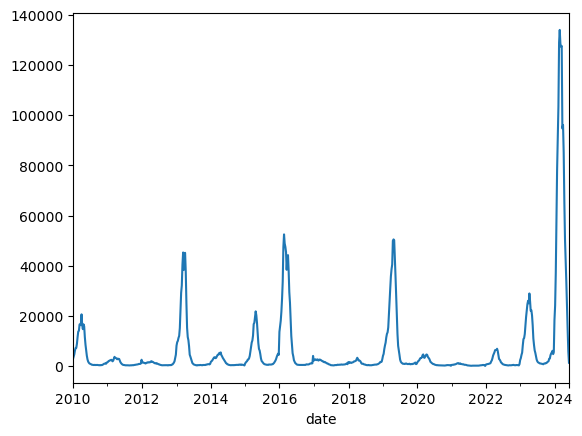

In [5]:
df_w['casos'].plot()

In [6]:
df_w['casos_totais'] = pd.NA

for year in df_w.year.unique():

    df_w.loc[df_w.year == year, 'casos_totais'] = df_w.loc[(df_w.year == year)].casos.sum()


df_w.head()

,casos,epiweek_label,epiweek,year,casos_totais
date,,,,,
2010-01-03,2794,201013,13,2010,258066
2010-01-10,3729,201014,14,2010,258066
2010-01-17,4656,201015,15,2010,258066
2010-01-24,6195,201016,16,2010,258066
2010-01-31,7179,201017,17,2010,258066


df_w['enso'] = pd.NA

[2012, 'La Niña'],
       [2013, 'La Niña'],
       [2014, 'La Niña'],
       [2015, 'El Niño'],
       [2016, 'El Niño'],
       [2017, 'La Niña'],
       [2018, 'La Niña'],
       [2019, 'El Niño'],
       [2020, 'El Niño'],
       [2021, 'La Niña'],
       [2022, 'La Niña'],
       [2023, 'La Niña']

Testar o modelo para 2019 e para 2022. 

In [7]:
def get_train_data(df_w_train): 

    columns_to_normalize = ['casos', 'epiweek', 'casos_totais']

    norm_values = df_w_train.max()[columns_to_normalize]
    

    df_w_train[['casos', 'epiweek', 'casos_totais']] = df_w_train[['casos', 'epiweek', 'casos_totais']]/norm_values
    
    min_year = df_w_train.index.year.min() + 2

    if min_year <=2012:
        min_year = 2013

    X_train = np.empty((0, 2, 3))
    
    y_train = np.empty((0, 1))
        
    for year, week in product(np.arange(min_year, df_w_train.index.year.max()), np.arange(1,53)): 
        
        if week <=9:
            week_str = f'0{week}'
        else:
            week_str = str(week)
        try:
            last_2 = np.array([df_w_train.loc[(df_w_train.epiweek_label == f'{year-2}{week_str}')][['epiweek', 'casos', 'casos_totais']].values[0]]).reshape(1, 1,-1)
        
            last_1 = np.array([df_w_train.loc[(df_w_train.epiweek_label == f'{year-1}{week_str}')][['epiweek', 'casos', 'casos_totais']].values[0]]).reshape(1, 1,-1)
        
            last_values = np.array(np.append(last_2, last_1, axis=1))
                
            X_train = np.append(X_train, last_values, axis = 0)
        
            y_train = np.append(y_train, np.array([df_w_train.loc[(df_w_train.epiweek_label == f'{year}{week_str}')][['casos']].values[0]]).reshape(1,-1),
                               axis = 0)

        except:
            print(year)
            print(week)
            pass 
            

    return X_train.astype(np.float32), y_train.astype(np.float32), norm_values 


def get_test_data(norm_values, df_w_test):
    '''
    Essa função gera os dados de teste apenas para uma ano específico. 
    '''

    norm_values = norm_values[['casos', 'epiweek', 'casos_totais']]

    df_w_test[['casos', 'epiweek', 'casos_totais']] = df_w_test[['casos', 'epiweek', 'casos_totais']]/norm_values

    year  = df_w_test.index.year.max()

    X_test = np.empty((0, 2, 3))
    
    y_test = np.empty((0, 1))
        
    for week in np.arange(1,53):

        if week <=9:
            week_str = f'0{week}'
        else:
            week_str = str(week)
            
        try:
            last_2 = np.array([df_w_test.loc[(df_w_test.epiweek_label == f'{year-2}{week_str}')][['epiweek', 'casos', 'casos_totais']].values[0]]).reshape(1, 1,-1)
            
            last_1 = np.array([df_w_test.loc[(df_w_test.epiweek_label == f'{year-1}{week_str}')][['epiweek', 'casos', 'casos_totais']].values[0]]).reshape(1, 1,-1)
            
            last_values = np.array(np.append(last_2, last_1, axis=1))
                    
            X_test = np.append(X_test, last_values, axis = 0)
            
            y_test = np.append(y_test, np.array([df_w_test.loc[(df_w_test.epiweek_label == f'{year}{week_str}')][['casos']].values[0]]).reshape(1,-1),
                                   axis = 0)
        except: 
            pass

    return X_test.astype(np.float32), y_test.astype(np.float32)
    
    

In [8]:
df_w.dtypes

casos             int64
epiweek_label    object
epiweek           int64
year              int64
casos_totais     object
dtype: object

In [9]:
df_w[['casos', 'epiweek', 'casos_totais']]/df_w.max()[['casos', 'epiweek', 'casos_totais']]

,casos,epiweek,casos_totais
date,,,
2010-01-03,0.020855,0.25,0.160248
2010-01-10,0.027834,0.269231,0.160248
2010-01-17,0.034754,0.288462,0.160248
2010-01-24,0.046241,0.307692,0.160248
2010-01-31,0.053586,0.326923,0.160248
...,...,...,...
2024-05-05,0.249293,0.596154,1.0
2024-05-12,0.174321,0.615385,1.0
2024-05-19,0.107829,0.634615,1.0


In [10]:
df_w.max()[['casos', 'epiweek', 'casos_totais']]

casos            133971
epiweek              52
casos_totais    1610415
dtype: object

In [11]:
X_train, y_train, norm_values = get_train_data(df_w.loc[df_w.year < 2023])

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_25757/4133917290.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_train[['casos', 'epiweek', 'casos_totais']] = df_w_train[['casos', 'epiweek', 'casos_totais']]/norm_values


In [12]:
X_test, y_test = get_test_data(norm_values, df_w.loc[df_w.year <= 2023])

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_25757/4133917290.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_test[['casos', 'epiweek', 'casos_totais']] = df_w_test[['casos', 'epiweek', 'casos_totais']]/norm_values


### Model

In [13]:
from time import time
import tensorflow as tf
from keras import layers
import keras.backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import LSTM, Attention, Dense, Dropout, Bidirectional, Flatten, Conv1D, Concatenate #, ConvLSTM1D, TimeDistributed
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, mean_squared_log_error, \
    median_absolute_error, r2_score
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
from tensorflow.keras.activations import gelu 
from keras.optimizers import Adam#, RMSprop

In [14]:
def build_baseline( hidden=8, features=100, predict_n=4, look_back=4, loss='msle', optimizer = 'adam',  stateful = False, batch_size = 1):

    inp = keras.Input(
        #shape=(look_back, features),
        batch_shape=(batch_size, look_back, features)
    )

    x = LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful = stateful,
        
        return_sequences=True,
    )(inp, training=True)

    x = Dropout(0.2, name='dropout_3')(x, training=True)  

    x = LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful = stateful,
        activation = gelu, 
        
        return_sequences=False,
    )(inp, training=True)


    x = Dropout(0.2)(x, training=True)    

    x = LSTM(
        hidden,
        input_shape=(look_back, features),
        stateful = stateful,
        activation = gelu, 
        
        return_sequences=False,
    )(inp, training=True)


    x = Dropout(0.2)(x, training=True)    
        
    out = Dense(
        predict_n,
        activation='relu'
    )(x)
        #activity_regularizer=regularizers.L2(l2) )(x)
    model = keras.Model(inp, out)

    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy", "mape", "mse"])
    print(model.summary())
    return model

In [15]:
X_train.shape

(468, 2, 3)

In [16]:
model = build_baseline( hidden=128,
                       features=3, predict_n=1, look_back=2, loss='msle', optimizer = 'adam')

model

/opt/homebrew/Caskroom/miniforge/base/envs/use_tensorflow/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (1, 2, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (1, 128)               │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 1)                 │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,713 (264.50 KB)

 Trainable params: 67,713 (264.50 KB)

 Non-trainable params: 0 (0.00 B)

None


<Functional name=functional_1, built=True>

In [17]:
TB_callback = TensorBoard(
        log_dir="./tensorboard",
        histogram_freq=0,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        # embeddings_freq=10
    )

seed = 7
epochs = 100
verbose = 1
monitor = 'loss'
min_delta = 0
patience = 20

In [18]:
%%time
hist = model.fit(
            X_train,
            y_train,
            batch_size=1,
            epochs=epochs,
            verbose=verbose,
            callbacks=[TB_callback, EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience)]
        )


Epoch 1/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0234 - mape: 457.1144 - mse: 0.0421
Epoch 2/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0160 - mape: 321.9008 - mse: 0.0302
Epoch 3/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0183 - mape: 304.8484 - mse: 0.0355
Epoch 4/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0140 - mape: 267.7303 - mse: 0.0259
Epoch 5/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0195 - mape: 324.9097 - mse: 0.0378
Epoch 6/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0139 - mape: 272.8723 - mse: 0.0252
Epoch 7/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0154 - mape: 338.0994 - mse: 0.0283
Epoch 8/100
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0164 - mape: 260.9068 - mse: 0.0316
Epoch 9/100
468/468 ━━━━

In [19]:
y_ = model.predict(X_test.astype(np.float32))

predicted = np.stack([model(X_test.astype(np.float32), training =True) for i in range(100)], axis=2)


predicted.shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


(52, 1, 100)

In [20]:
df_pred = pd.DataFrame(np.percentile(predicted, 50, axis=2))
df_pred25 = pd.DataFrame(np.percentile(predicted, 2.5, axis=2))
df_pred975 = pd.DataFrame(np.percentile(predicted, 97.5, axis=2))


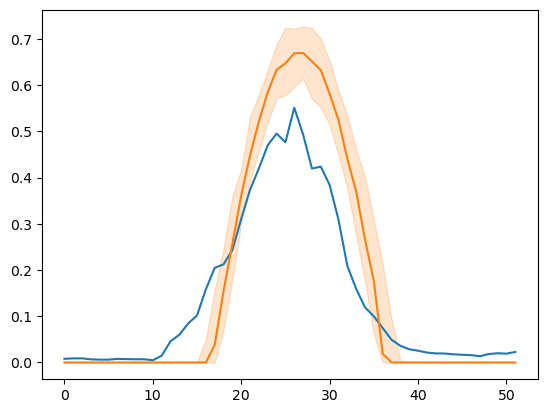

In [21]:
fig, ax = plt.subplots()

ax.plot(y_test, label = 'Data')

ax.plot(df_pred, label = 'preds')

ax.fill_between( np.arange(0, 52), df_pred25.values.reshape(1,-1)[0], df_pred975.values.reshape(1,-1)[0], color = 'tab:orange', alpha = 0.2)
plt.show()

In [22]:
model.save(f"models/base_dengue_MG_2023.keras")